In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
import math
from scipy.signal import decimate, convolve

In [75]:
RawData = "rawdata/probeX.data"
f = open(RawData, "r")
a = np.fromfile(f, dtype=np.uint32)
t = a[-1]
V = a[:-1].copy()
T = [ (( x * t ) / ( 1000.0*len(V) )) for x in 2*range(len(V))]
Tt = [ (( x * t ) / ( 1000.0*len(V) )) for x in range(len(V))]
Fech = 1000.0*len(V)/t # in MHz

In [70]:
#ADC1_pins = [21,22,19,15,13,11,12,10, 8]
ADC1_pins = [21,22,19,15,13,11,12,10, 8]
ADC2_pins = [38,37,36,35,33,32,26,24,23]

#ADC1_GPIO = [9, 25,10,22,27,17,18,15,14]
ADC1_GPIO =  [9 ,25,10,22,27,17,18,15,14]
ADC2_GPIO = [20,26,16,19,13,12, 7, 8,11]

ADC1len = len(ADC1_GPIO)
ADC2len = len(ADC2_GPIO)


def MoreInfos(Volts):
    PWM = []
    GPIO21 = []
    for i in range(len(Volts)):
        val = int(V[i])
        GPIO21.append(150*(val & 2**21)/2**21)
        PWM.append(150*(val & 2**6)/2**6)
            
    return PWM,GPIO21

def GetV2(Volts):
    Signal = []
    Map = np.zeros((len(V),ADC2len), dtype=np.int)
    for i in range(len(Volts)):
        val = int(V[i])
        SignalZero = 0
        for k in range(ADC2len):
            Map[i][k] = (val & 2**k)/2**k
        for k in range(ADC2len):
            SignalZero += 2**k*((val & 2**ADC2_GPIO[k])/2**ADC2_GPIO[k])
        Signal.append(SignalZero)

            
    return Signal,Map



def GetV1(Volts):
    Signal = []
    Map = np.zeros((len(V),ADC1len), dtype=np.int)
    for i in range(len(Volts)):
        val = int(V[i])
        SignalZero = 0
        for k in range(ADC1len):
            Map[i][k] = (val & 2**k)/2**k
        for k in range(ADC1len):
            SignalZero += 2**k*((val & 2**ADC1_GPIO[k])/2**ADC1_GPIO[k])
        Signal.append(SignalZero)

            
    return Signal,Map

In [169]:
PWM,GPIO21 = MoreInfos(V)

In [170]:
M = GetV2(V)[0]
M2 = GetV1(V)[0]
Ma = M - np.average(M)
Mb = M2 - np.average(M2)
rawSig = []
for k in range(len(Ma)):
    rawSig.append(Mb[k])
    rawSig.append(Ma[k])

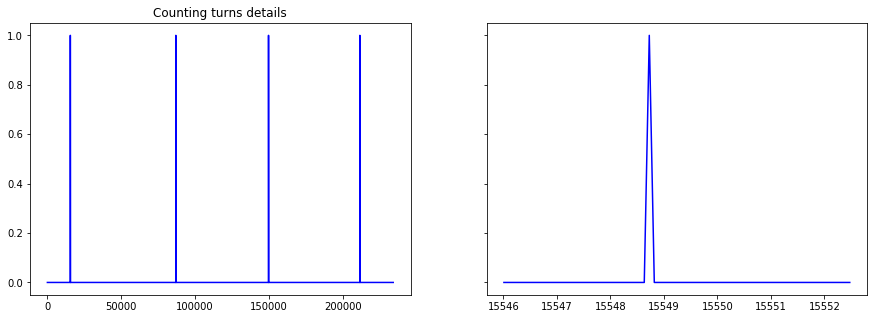

In [171]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))
ax1.plot(Tt,GPIO21,"b")
ax1.set_title('Counting turns')
ax2.plot(Tt[165950:166020],GPIO21[165950:166020],"b")
ax1.set_title('Counting turns details')
plt.show()

In [172]:
BeginningLines = [2*x/5000 for x in np.nonzero(GPIO21)][0]

In [173]:
FFT = np.fft.fft(rawSig)
FFTCleaned = np.fft.fft(rawSig)
for k in range(len(FFTCleaned)/2):
    if (k < 350000 or k > 790000): # in (k < 550000 or k > 790000)
        FFTCleaned[k] = 0
        FFTCleaned[-k] = 0
    
Scale = max(FFT)
ff = [ Fech*2.0*x/(2*len(V)) for x in range(len(V))]

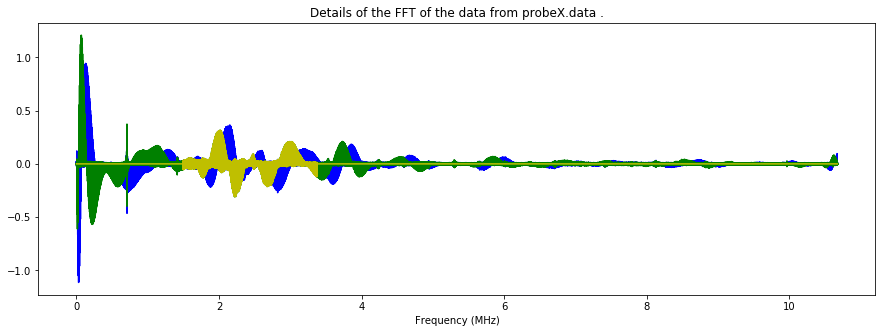

In [174]:
plt.figure(figsize=(15,5))
plt.plot(ff,np.real(FFT)[0:len(FFT)/2]/Scale,"b")
plt.plot(ff,np.imag(FFT)[0:len(FFT)/2]/Scale,"g")
plt.plot(ff,np.imag(FFTCleaned)[0:len(FFT)/2]/Scale,"y")
plt.title("Details of the FFT of the data from "+RawData.split("/")[-1]+" .")  
plt.xlabel("Frequency (MHz)")
plt.savefig('Imgs/fft_'+RawData.split("/")[-1]+".jpg", bbox_inches='tight')
plt.show()

In [175]:
F = np.real(np.fft.ifft(FFTCleaned))
FH = np.asarray(np.abs(signal.hilbert(F)))

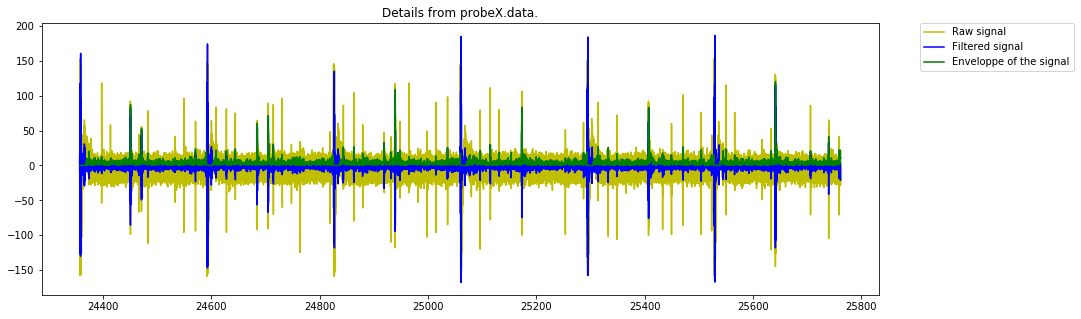

In [197]:
IndexLine = 104
tt = IndexLine*2500
plt.figure(figsize=(15,5))
TT = np.divide(T,2.0)
plt.plot(TT[2*tt:2*tt+2*15000],rawSig[2*tt:2*tt+2*15000],"y", label='Raw signal')
plt.plot(TT[2*tt:2*tt+2*15000],np.real(np.fft.ifft(FFTCleaned))[2*tt:2*tt+2*15000],"b", label='Filtered signal')
plt.plot(TT[2*tt:2*tt+2*15000],FH[2*tt:2*tt+2*15000],"g", label='Enveloppe of the signal')
plt.title("Details from "+RawData.split("/")[-1]+".")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Imgs/datas_'+RawData.split("/")[-1]+'.jpg', bbox_inches='tight')
plt.show()

In [177]:
tableData = np.asarray(FH).reshape((1000,2*2500))
tableDataRaw = np.asarray(rawSig).reshape((1000,2*2500))

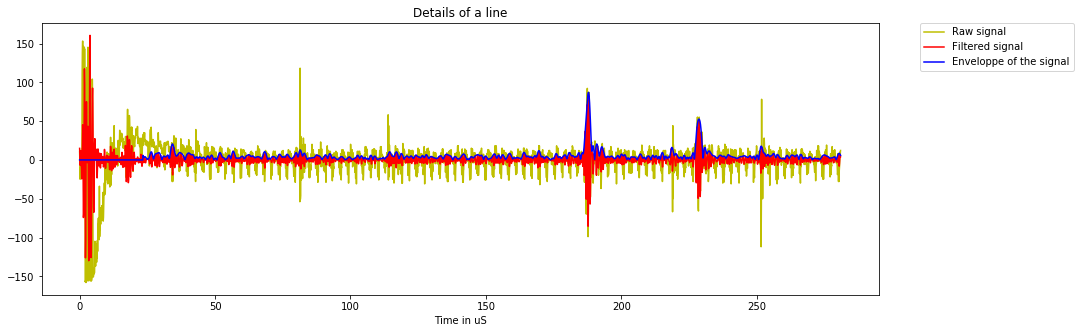

In [193]:
ExLine = tableData[IndexLine]
ExLineRaw = tableData[IndexLine]
plt.figure(figsize=(15,5))
plt.plot(T[0:3000],rawSig[5000*IndexLine:5000*IndexLine+3000],"y", label='Raw signal')
plt.plot(T[0:3000],F[5000*IndexLine:5000*IndexLine+3000],"r", label='Filtered signal')
plt.plot(T[0:3000],ExLine[0:3000],"b", label='Enveloppe of the signal')
plt.title("Details of a line")
plt.xlabel("Time in uS")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [179]:
for m in range(250):
    for k in range(1000):
        tableData[k][m] = 0.0

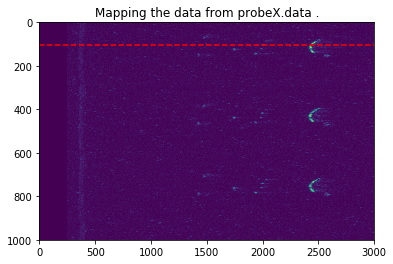

In [180]:
tableData = tableData[:,:3000]
plt.imshow((abs(tableData)), aspect='auto')
plt.axhline(IndexLine, color='r', linestyle='--')
plt.title("Mapping the data from "+RawData.split("/")[-1]+" .")  
plt.savefig('Imgs/map_'+RawData.split("/")[-1]+".jpg", bbox_inches='tight')
plt.show()

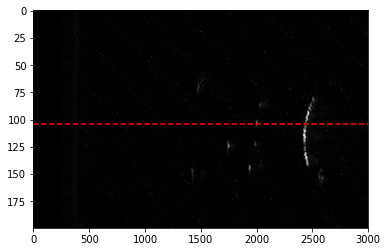

In [195]:
Start =0
Stop = 200 
TmpImg = (abs(tableData[Start:Stop]))**(1.3)
plt.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
plt.axhline(IndexLine, color='r', linestyle='--')
plt.savefig('Imgs/mapCleanImage_'+RawData.split("/")[-1]+str(Start)+"-"+str(Stop)+".jpg", bbox_inches='tight')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in power


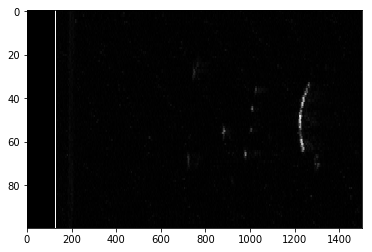

In [196]:
DecImg = []
for i in range(200):
    DecImg.append(decimate(tableData[650+i], 2, ftype='fir'))
SmallImg = []
for i in range(len(DecImg)/2):
    SmallImg.append((DecImg[2*i]+DecImg[2*i+1])/2)
#plt.axhline(IndexLine/2, color='r', linestyle='--')
plt.imshow(np.asarray(SmallImg)**(1.3),cmap=plt.get_cmap('gray'), aspect='auto')
plt.savefig('Imgs/mapCleanImageDec_'+RawData.split("/")[-1]+str(Start)+"-"+str(Stop)+".jpg", bbox_inches='tight')
plt.show() 

In [183]:
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]
    NbLinesC = np.shape(RawImgData)[0]
    SC = np.zeros((LenLinesC,LenLinesC))
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.int)
    
    return SC,values,points,LenLinesC

In [190]:
SCH,valuesH,pointsH,LenLinesCH = CreateSC(SmallImg)
grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app


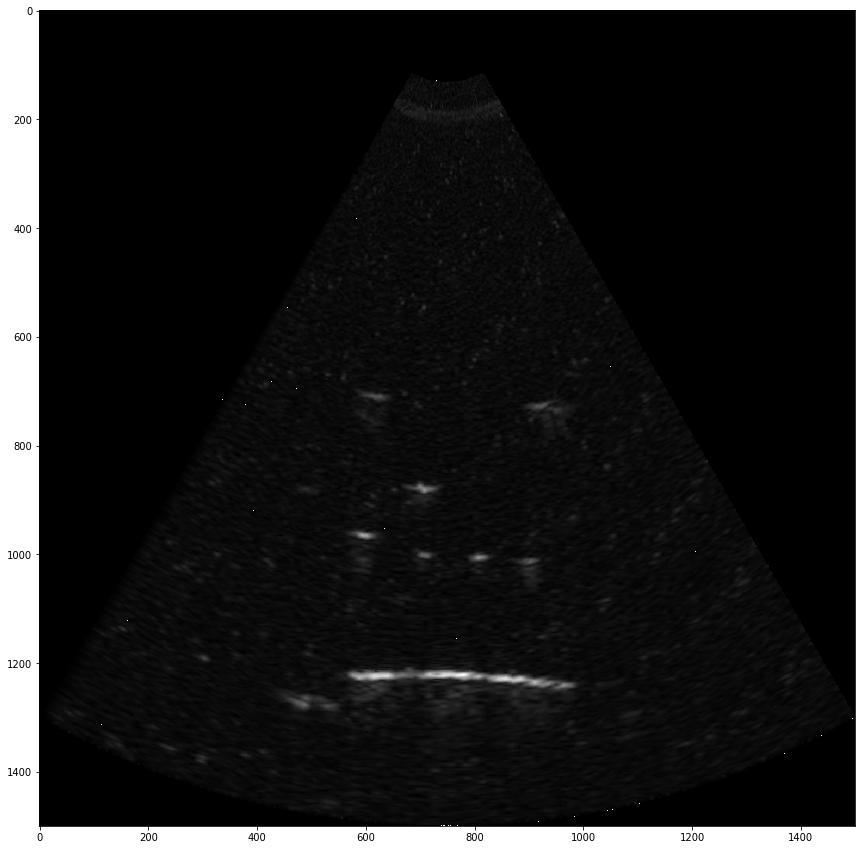

In [191]:
plt.figure(figsize=(15,15))
plt.imshow((grid_z1H**0.8),cmap=plt.get_cmap('gray')) 
plt.show()